<a href="https://colab.research.google.com/github/nsydn/time-series-analysis-and-forecasting/blob/main/notebooks/02/stationarity_NSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stationarity

## Introduction

- Previously, we learned that time series is data that is measured at equally-spaced intervals.
- We also learned that time series data can be decomposed into three parts: trend, seasonality, and residuals.
- Now we'll dig deeper by discussing an important concept called **stationarity**.
- Having a firm grasp of this concept will lay the foundation necessary to understand more advanced modeling strategies that we'll introduce later on.

In this lecture we will cover
- Definition of stationarity and examples of common stationary and nonstationary time series.
- How to detect stationarity.
- The most common ways to transform nonstationary time series into stationary ones.

In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(0) # Reproducibility

---

## Stationary Time Series

### Why is stationarity important?

- Stationarity is a fundamental assumption in many time series forecasting models.
- Without it many basic time series models would break.
- Transformations can be applied to convert a nonstationary time series to a stationary one.
- There are advanced time series models that can handle nonstationary data (beyond the scope of this lecture).

### What is stationarity?

- 💡 Intuition: a time series is stationary when there are no changes in the underlying system that generates it.
- In the following, we define:
    - Strict stationarity.
    - Weak stationarity.
    - Things to check in practice.

#### Strict stationarity

<!-- - A time series $X(t): t \in \mathcal{T}$ is called strictly stationary if, for all $t_1, t_2, \dots, t_n \in \mathcal{T}$ and $h$ such that $t_1+h, t_2+h, \dots, t_n+h \in \mathcal{T}$, it holds that -->

- A time series $X(t): t \in \mathcal{T}$ is called strictly stationary if

$$\big(X(t_1),X(t_2), \dots, X(t_n)\big) \stackrel{\text{D}}{=} \big(X(t_1+h),X(t_2+h), \dots, X(t_n+h)\big)$$

where $\stackrel{\text{D}}{=}$ indicates that the distributions are equal.
- In plain words, the joint distribution of any set of observations in the series remains the same regardless of the time at which the observations are taken.

- Strict stationarity is very difficult to verify, especially from a limited amount of data.
- For this reason, one checks the *Weak stationarity*.

#### Weak stationarity

- A time series $X$ is weakly stationary if:

  1. The mean is constant over time $\mathbb{E}[X(t)] = m, \;\; \forall t \in \mathcal{T}$
  2. The variance is finite $\mathbb{E}[X(t)^2] < \infty, \;\; \forall t \in \mathcal{T}$
  3. The covariance of $X(t)$ and $X(t+h)$ depends only on $h$, i.e., is shift-invariance in time.

- Strict stationarity implies weak stationarity, but not the opposite.

#### Things to check in practice.

1. Constant mean (no trend).
2. Constant variance (no heteroskedasticity).
3. Constant autocorrelation structure.
4. No periodic component (✋ careful here)

- Mean, variance, and periodic component (aka seasonality) should be familiar from the previous lecture.
- Autocorrelation may not be.
- Let's start with a simple example of a stationary time series.

- First, we create a variable `time` that defines equally-spaced time intervals.
- Then we'll sample values from a Normal distribution with a mean of 0 and a standard deviation of 1.
- Essentially we're creating white noise, which is a stationary time series as it exhibits all the properties required of a stationary time series.

In [7]:
time = np.arange(200)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

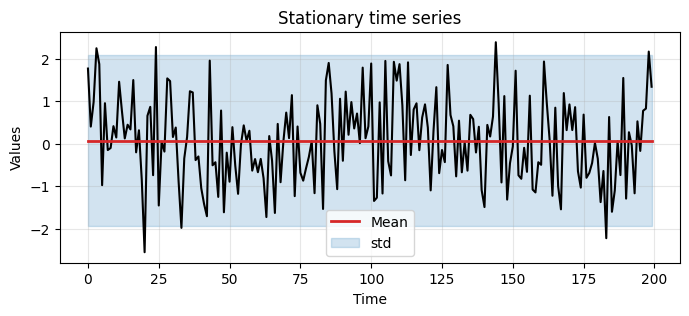

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8, 3))
ax.plot(time, stationary, 'k-')
ax.set_title('Stationary time series')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.grid(alpha=0.3)
ax.plot(time, np.ones_like(time)*np.mean(stationary), linewidth=2, color='tab:red', label='Mean');
ax.fill_between(time, np.ones_like(time)*(stationary.mean()-1.96*stationary.std()),
                np.ones_like(time)*(stationary.mean()+1.96*stationary.std()), color='tab:blue', alpha=0.2, label='std')
plt.legend()

- We can easily check that the white noise has constant mean, constant variance, and no periodicity.
- What about the autocorrelation?

#### Autocorrelation (`simplify`)
- Autocorrelation measures how much the current time series measurement is correlated with a past measurement.
- For example, today's temperature is often highly correlated with yesterday's temperature.
- Autocorrelation often results in a pattern, whereas a time series without autocorrelation looks random.
- To discuss these things we must introduce the idea of a *lag*, i.e., a delay.


*   A simple and useful way to detect auto-correlation visually is to look at auto-correlation and partial auto-correlation graphs, namely, **ACF and PACF**.
* A slow decay in the ACF and a sharp cut-off in PACF may imply auto-correlation (thus, non-stationarity) in time series



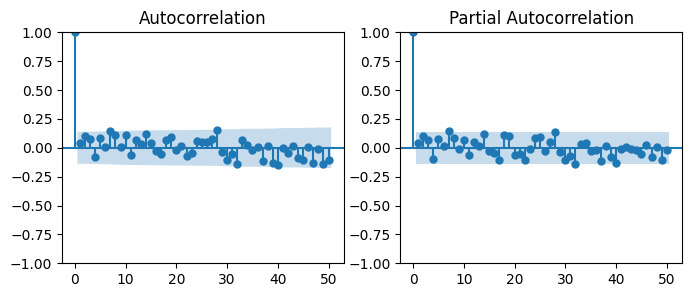

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(8, 3))
plot_acf(stationary, lags=50, ax=ax[0])
plot_pacf(stationary, lags=50, ax=ax[1])
plt.show()

### Common stationary and nonstationary time series

- If the analytic expression of the time series is known, it is possible to check the conditions for stationarity.
- In practice, the process generating the time series might be unknown and we'll need other tools to check stationarity.
- Starting the analysis by looking at the `run_sequence_plot` is an excellent starting point.

#### White noise

- We already looked at this time series and conclude that mean and variance are constant and there is no seasonal component.
- In addition, since the random value at each time step is drawn independently, there is no correlation.

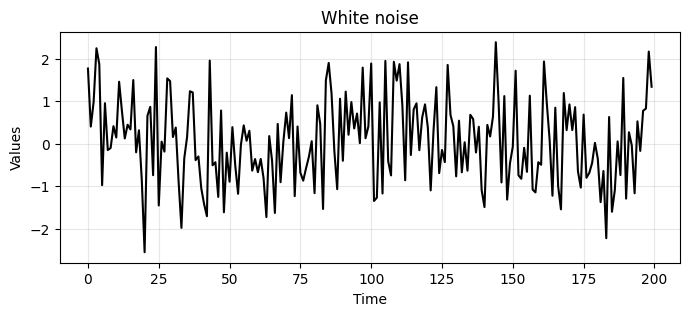

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 3))
ax.plot(time, stationary, 'k-')
ax.set_title('White noise')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.grid(alpha=0.3)

#### Random walk

- The random walk is one of the most important nonstationary time series.
- It is defined as:

$$X(t) = X(t-1) + \epsilon_t$$  

- where $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$ are called *innovations* (or *residuals*) and are i.i.d. (independent and identically distributed).
- Let's create a random walk.

In [11]:
# empty series
rand_walk = np.empty_like(time, dtype='float')

# initial value
rand_walk[0] = 3.14

# Random Walk
for t in time[1:]:
    rand_walk[t] = rand_walk[t-1] + np.random.normal(loc=0, scale=2.5, size=1)[0]

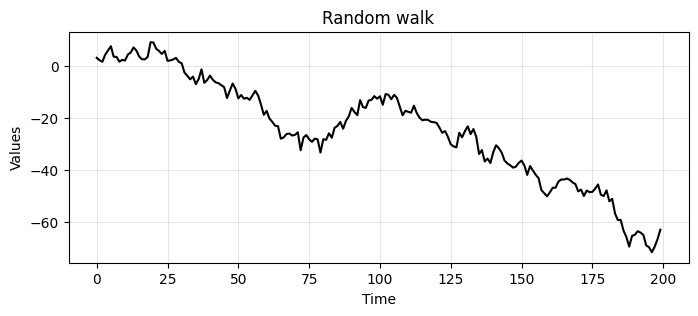

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8, 3))
ax.plot(time, rand_walk, 'k-')
ax.set_title('Random walk')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.grid(alpha=0.3)

- Notice:
>* how the current value is highly correlated with the past values
>* how this causes a trend (non-constant mean)
- The random walk is obviously nonstationary.
- Why 🤔?

**Dependence on Initial Value**

- The value of the series at any timepoint depends on its initial value and the sum of all previous innovations.
- Clearly, this path dependence implies non-stationarity.

**Changing variance**

- In a random walk, the variance increases linearly over time because the effects of the innovations accumulate..
- This violates condition #2 of weak stationarity.
- Let's see this in detail.

At a general time $t$ we have:
   - $X(t) = X(t-1) + \epsilon_t = X(0) + \epsilon_1 + \epsilon_2 + \ldots + \epsilon_t$,
   - Using the independence of the $\epsilon$ terms and the fact that each has variance $\sigma^2$ we get
   
   $$\text{Var}(X(t)) = \text{Var}(\epsilon_1) + \text{Var}(\epsilon_2) + \ldots + \text{Var}(\epsilon_t) = t\sigma^2$$

#### Time series with trend

- Consider the following data.

In [13]:
trend = (time * 2.75) + stationary

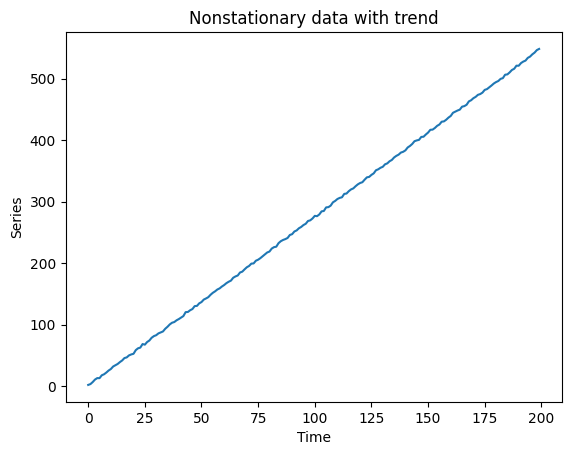

In [19]:
plt.plot(time, trend)
plt.title("Nonstationary data with trend")
plt.xlabel("Time")
plt.ylabel("Series");

  - Is this data stationary?

- No, the mean changes over time and violates condition #1.

#### Heteroscedastic time series

In [21]:
level_1 = np.random.normal(loc=0, scale=1.0, size = 100)
level_2 = np.random.normal(loc=0, scale=10.0, size = 100)
heteros = np.append(level_1, level_2)

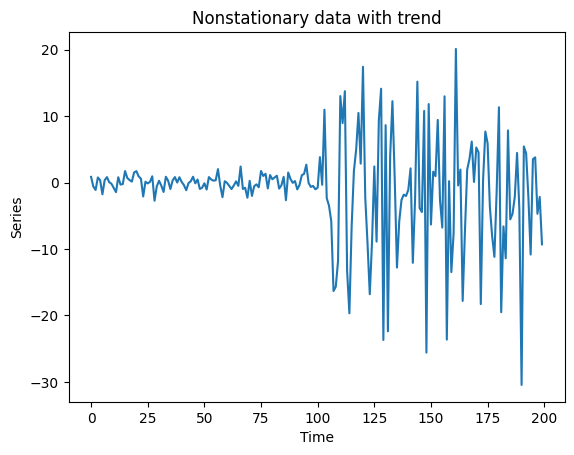

In [22]:
plt.plot(time, heteros)
plt.title("Nonstationary data with trend")
plt.xlabel("Time")
plt.ylabel("Series");

- Is this data stationary?

- No, the variance changes over time.

#### Time series with seasonality

In [25]:
seasonality = 20 + np.sin(2*np.pi*time/12)*20

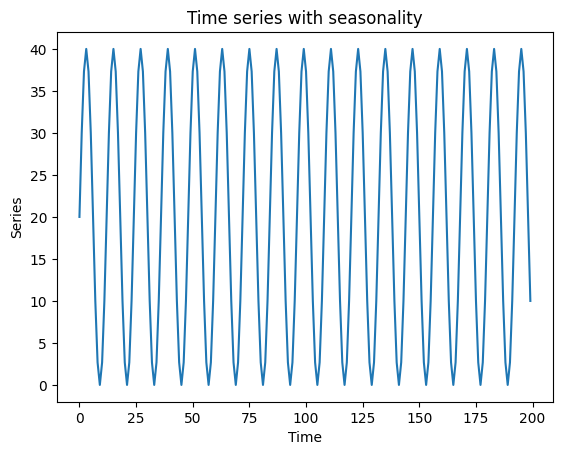

In [26]:
plt.plot(time, seasonality)
plt.title("Time series with seasonality")
plt.xlabel("Time")
plt.ylabel("Series");

- Is this time series stationary?

- The mean of a periodic signal over a complete cycle always assumes the same value (`20` in our case).
- However, over an half-cycle or any period not equal to an integer multiple of the full cycle, the mean changes (is different from `20`).
- This violates condition #1.

<img src="https://github.com/nsydn/time-series-analysis-and-forecasting/blob/main/notebooks/02/media/periodic_mean.png?raw=1" style="width: 40%; display: block; margin: auto;">

- Similarly, the variance depends on the time interval over which it is measured.
- Since the signal's amplitude varies, the variance calculated over different phases of the sinusoid will also vary.
- This violates condition #2.
- A similar argument also hold for the autocorrelation, which violates condition #3.

- So, no, the time series is not stationary.

#### Time series with trend and seasonality

In [27]:
trend_seasonality = trend + seasonality + stationary

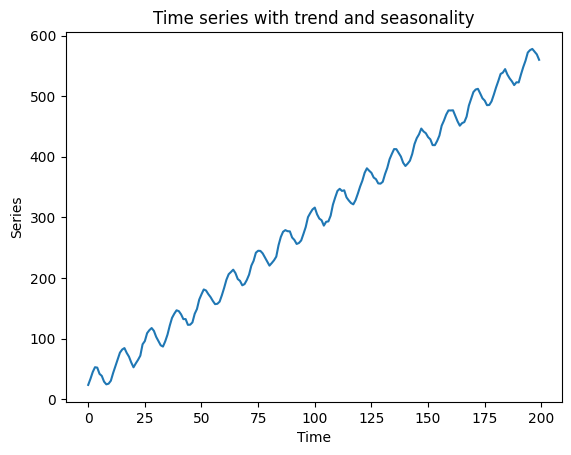

In [28]:
plt.plot(time, trend_seasonality)
plt.title("Time series with trend and seasonality")
plt.xlabel("Time")
plt.ylabel("Series");

- Is this data not stationary?

- No, the mean changes over time because of the trend AND there is a periodic component.

---

## Detecting stationarity

Next, we will review practical techniques used to identify if a time series is stationary or not.

Specifically, we will cover:
1. Time plots
2. Summary statistics
3. Histogram plots
4. Augmented Dickey-Fuller test

### Time Plots

- Run time plots allows to visualize what's happening with the data.
- This should always be your starting point.
- Indeed, that is what we have been doing so far with our function `plot_TS`.
- It often shows whether there is an underlying structure.
- Be on the lookout for trend, seasonality, and autocorrelation.

### Summary Statistics

- An easy way to check for constant mean and variance is to chop up the data into separate chunks.
- Then, one calculates statistics for each chunk, and compare them.
- Large deviations in either the mean or the variance among chunks might indicate that the time series is nonstationary.
- It's not a rigorous method but gives a good hint of whether the data is approximately stationary or not.

<img src="https://github.com/nsydn/time-series-analysis-and-forecasting/blob/main/notebooks/02/media/stationary_chunk.png?raw=1" width=800; style="width: 45%; display: block; margin: auto;">

<img src="https://github.com/nsydn/time-series-analysis-and-forecasting/blob/main/notebooks/02/media/nonstationary_chunk.png?raw=1" width=800; style="width: 45%; display: block; margin: auto;">

- Let's look at an example based on the `trend` time series that we created before.

In [29]:
# split data into 10 chunks
chunks = np.split(trend, indices_or_sections=10)

Summary statistics:

In [30]:
# compare means and variances
for i, chunk in enumerate(chunks, 1):
    print(i, 'mean: %.2f, var: %.2f' % (np.mean(chunk), np.var(chunk)))

1 mean: 26.69, var: 241.23
2 mean: 81.18, var: 255.62
3 mean: 135.73, var: 258.47
4 mean: 190.77, var: 257.08
5 mean: 246.55, var: 257.82
6 mean: 301.62, var: 259.15
7 mean: 356.19, var: 249.28
8 mean: 411.09, var: 244.11
9 mean: 466.14, var: 245.37
10 mean: 520.99, var: 275.11


- While the variance is relatively constant over time, the mean is clearly changing, which means this data is not stationary.
- We do expect some fluctuation in values.
- It's highly unlikely that the either the mean or variance will be exactly the same from chunk to chunk, but it should be close.

- To see this better, it's a good idea to plot the means and variances.
- If you want to be more precise, you could run a statistical test to determine if the difference in means or the difference in variances is statistically significant.

### Histogram Plot

- Plotting a histogram of the time series gives important clues into its underlying structure.
- An histogram that looks like a Normal distribution suggests that mean and variance are constant.

- Let's start from the non-stationary time series with trend.

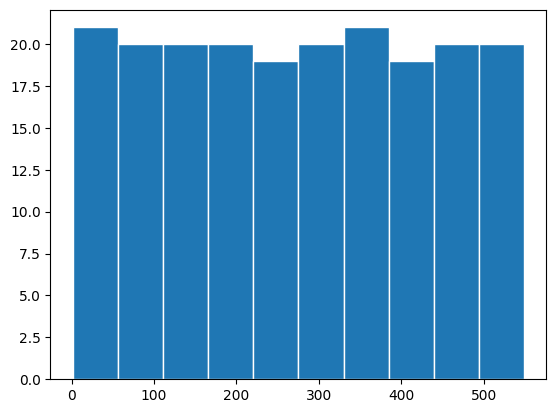

In [31]:
# pd.Series(trend).hist(figsize=(7,3));
plt.hist(trend, edgecolor='w');

- The histogram resembles an *uniform* distribution.
>- It doesn't have to be *uniform* though
- This is expected since `trend` is, indeed, not stationary.

- Let's try the same thing on the `stationary` data we created at the beginning.

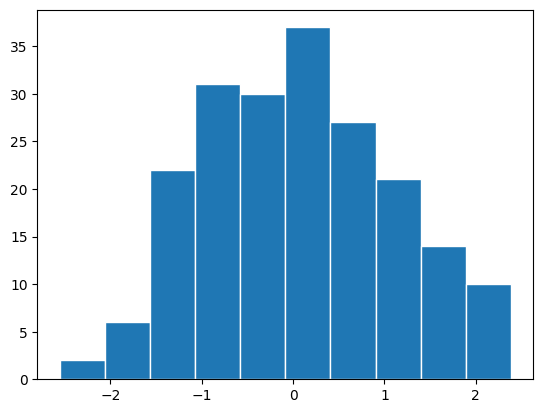

In [32]:
plt.hist(stationary, edgecolor='w');
# what about rand_walk?

- That definitely looks more approximately Normal.
<!-- - To be more precise, we could use SciPy's [normaltest](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mstats.normaltest.html) to test how much the histogram differs from a Normal distribution. -->

# **Week ??**

### Augmented Dickey-Fuller Test

- This is a statistical procedure to determine whether a time series is stationary or not.
- We will discuss more details about the test in the next lectures
- For now, that's what we need to know:
>* **Null hypothesis ($H_0$):** the series is non-stationary.
>* **Alternative hypothesis ($H_1$):** the series is stationary.

- Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null.
- The values $\alpha=0.05$ or $\alpha=0.01$, which yield a confidence of $95\%$ and $99\%$, respectively, are common choices.
<!-- Explain the paradox behind increasing confidence level -->

Example: $p = 0.0001 \rightarrow$ reject $H_0 \rightarrow$ the time series is stationary

Example: $p = 0.43 \rightarrow$ fail to reject $H_0 \rightarrow$ the time series is non-stationary

- **The ADF test might be inaccurate with small datasets or when heteroskedasticity is present.**
- It is best to pair ADF with other techniques (time plots, summary statistics, histograms, etc..).**

#### Stationary Data & ADF

- Let's see how to run this test in Python.

In [33]:
testval, pvalue, usedlag, nobs, critical_values, icbest = adfuller(stationary)

- Let's see and comment the main outputs from the ADF test.

In [34]:
print(f"ADF: {adf:.2f}")

ADF: -13.56


- First, `adf` is the value of the test statistic.
- The more negative the value, the more confident we can be that the series is stationary.
- Here we see a negative value.
- That may not mean anything to you just yet but `pvalue` should.

In [ ]:
print(f"p-value: {pvalue}")

p-value: 2.300172138070656e-25


- The `pvalue` is interpreted like any p-value.
- The `pvalue` should be compared with the confidence levels (e.g., $\alpha=0.05$ or $\alpha=0.01$).
- Based on the comparison, we reject or fail to reject $H_0$.
- Here ``pvalue`` is very close to zero so we **reject** the $H_0$ in favor of $H_A$ and conclude that the time series is stationary.

In [ ]:
print(f"nobs: {nobs}")

nobs: 199


- The variable `nobs` is simply the number of observations in the time series.

In [35]:
print(f"critical values: {critical_values}")

critical values: {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}


- Finally, ``critical_values`` are the test statistic thresholds for common significant levels.
- Here we see a test statistic lower than -2.87 is sufficient to reject $H_0$ at a significance level of 5%.

- You may have noticed two outputs we didn't discuss (``usedlag`` and ``icbest``).
- See [statsmodels docs](http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for a description of ``usedlag`` and ``icbest``.

#### ADF on time series with trend
- Next, we run the ADF test on the `trend` time series.

In [43]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(trend)
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: 0.82
p-value: 0.992


- As expected, we fail to reject $H_0$ that the time series `trend` is non-stationary.

### ADF on random walk

- Finally, we run the ADF test on the `rand_walk` time series.

In [44]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(rand_walk)
print(f"ADF: {adf:.2f}")
print(f"p-value: {pvalue:.3f}")

ADF: -0.07
p-value: 0.952


- As we discussed before, the random walk is non-stationary because its variance $\sigma^2t$ is not constant over time.
- In the next section, we'll learn how to make this time series stationary.

- Good news 😎. At this point, we have several tools at our disposal to figure out if a time series is stationary or not.

---

## Common transformations to achieve stationarity

- There are several ways to transform nonstationary time series data:

Transformation | Effect
:---|:---
Subtract trend | Constant mean
Apply log | Constant variance
Differencing | Remove autocorrelation
Seasonal differencing | Remove periodic component

- Often you will have to do several of these on one dataset.
- Note that this is just a small subset of the total possible ways to transform nonstationary time series.

### Subtract estimated trend & seasonality

- Let's run the ADF test before transforming.

In [46]:
adf_b4, pvalue_b4, _, _, _, _ = adfuller(trend_seasonality)
print(f"ADF: {adf_b4:.2f}")
print(f"p-value: {pvalue_b4:.3f}")

ADF: 1.01
p-value: 0.994


- Non-stationary as expected.
- Next, we apply the transformation.

In [ ]:
ss_decomposition = seasonal_decompose(x=trend_seasonality, model='additive', period=12)
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_residual = ss_decomposition.resid

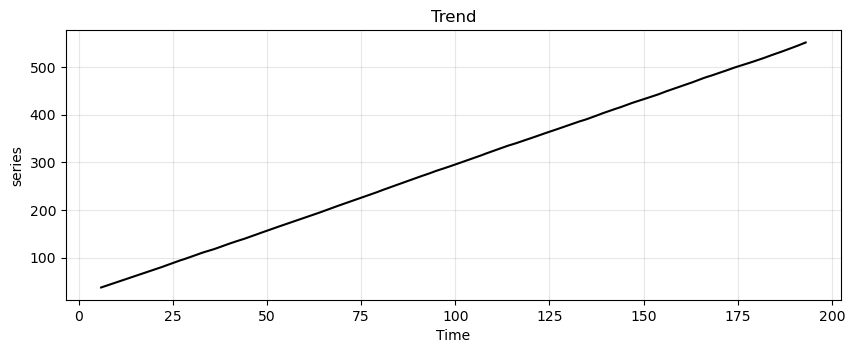

In [ ]:
run_sequence_plot(time, est_trend, title="Trend", ylabel="series");

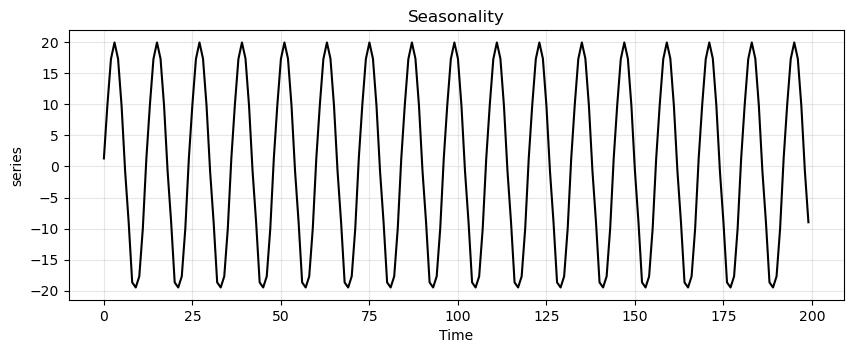

In [ ]:
run_sequence_plot(time, est_seasonal, title="Seasonality", ylabel="series");

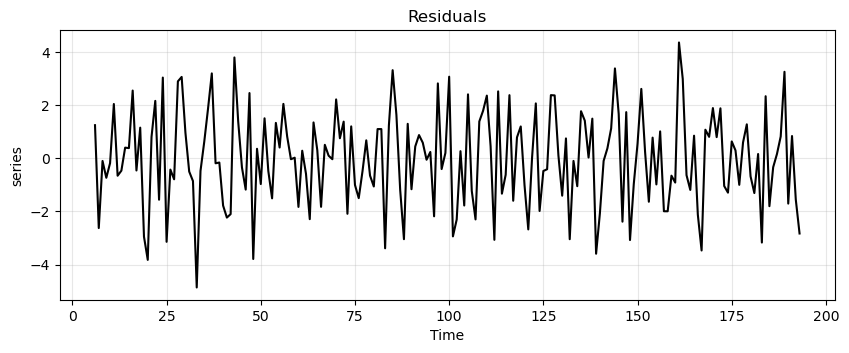

In [ ]:
run_sequence_plot(time, est_residual, title="Residuals", ylabel="series");

- Let's look at the residual values.

In [ ]:
print(est_residual)

[        nan         nan         nan         nan         nan         nan
  1.24368173 -2.62651313 -0.10234455 -0.73531189 -0.1829664   2.04130761
 -0.65755141 -0.46722156  0.39903068  0.38172731  2.54722749 -0.46031003
  1.15158029 -2.95123128 -3.8243952   0.80129202  2.15850427 -1.56043208
  3.0359116  -3.14443182 -0.42647195 -0.79241057  2.89305425  3.06029956
  0.96135096 -0.50108732 -0.85817676 -4.86262436 -0.47675426  0.62469458
  1.86733165  3.19296905 -0.18983981 -0.16068445 -1.78136305 -2.23271451
 -2.10183683  3.79310173  1.39263034 -0.34341253 -1.17970353  2.45314096
 -3.79055414  0.35619929 -0.97123041  1.50295994 -0.48073187 -1.50897278
  1.33062156  0.40333605  2.04519325  0.82223149 -0.03721313  0.02072604
 -1.83124467  0.28260905 -0.58713007 -2.29219567  1.34745638  0.30238082
 -1.82829117  0.50552599  0.09712559 -0.03657677  2.21367333  0.75259989
  1.3771748  -2.08987195  1.19900202 -1.00537537 -1.50116216 -0.48861264
  0.67380781 -0.65481532 -1.06292965  1.09813623  1

- We'll have to remove the first $6$ and last $6$ values to run an ADF test since those are `nan`.
- The number 6 is due to the fact that the method applies seasonal differencing and we specified `period=12`.
- Here's how to do that and run the test all in one call.

In [ ]:
adf_after, pvalue_after, _, _, _, _ = adfuller(est_residual[6:-6])
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -6.61
p-value: 0.000


- Now the time series is stationary ✌.

### Stabilize variance with log transform

- This trick is useful when dealing with heteroskedastic data.
- The log squashes the parts of the time series where the variance is higher.
- In this way, the variance becomes more uniform.
- Let's plot again the heteroskedastic times series to remember how it looks.

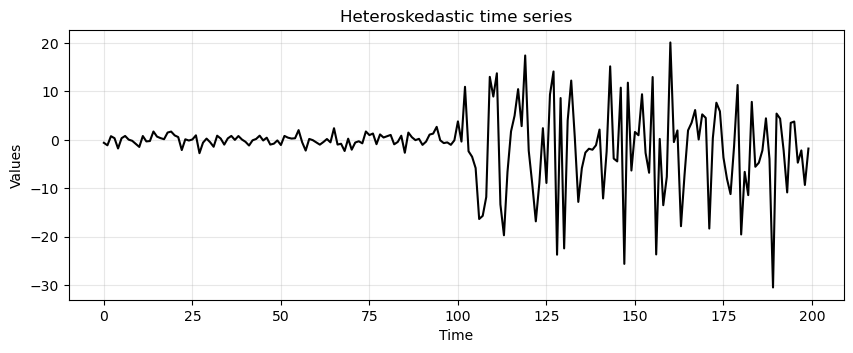

In [ ]:
run_sequence_plot(time, heteroscedasticity, title="Heteroskedastic time series");

- Let's run the ADF test.

In [ ]:
adf_b4, pvalue_b4, _, _, _, _ = adfuller(heteroscedasticity)
print(f"ADF: {adf_b4:.2f}")
print(f"p-value: {pvalue_b4:.3f}")

ADF: -3.66
p-value: 0.005


**⚠ Attention ⚠**

- ADF is saying we reject $H_0$ (at least at $\alpha=0.05$ confidence level) in favor of the alternative that the time series is stationary.
- However, the plot clearly shows that the variance is not constant over time.  

- This is an important lesson.
- Some statistical tests like ADF perform bad in some situations:
    - with few data,
    - when data is heteroskedastic.

- Let's now apply the log transformation.
- Before that, we subtract the minimum and add a small constant
- In this way we ensure that all values are positive.

In [ ]:
# Ensure all data are positive
new_hetero = heteroscedasticity - heteroscedasticity.min() + 1.0

# Apply the log
log_new_hetero = np.log(new_hetero)

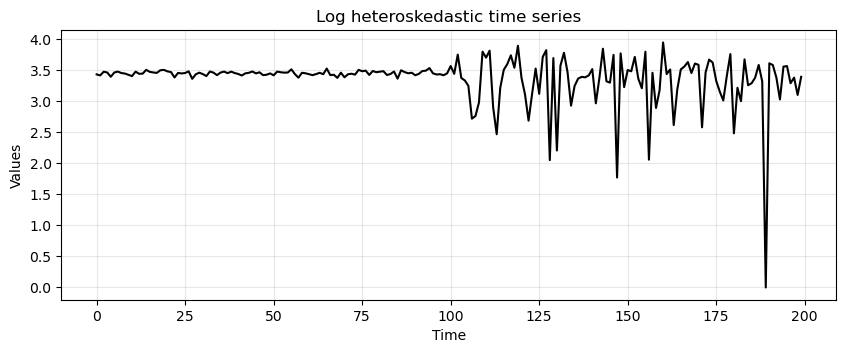

In [ ]:
run_sequence_plot(time, log_new_hetero, title="Log heteroskedastic time series");

- Look at the values on the $y$ axis.
- Notice how the variance has collapsed to a large extent.

📨 Takeaway message:

- The ADF test can fail to detect nonstationarity due to heteroskedasticity.
- Always plot the data.
- Do not rely on a single tool to determine stationarity.

### Removing autocorrelation with differencing

- Remember that the ADF test (correctly) indicated that the `rand_walk` time series is nonstationary.
- We can transform `rand_walk` into stationary time series by applying differencing.
- This is done by subtracting a past value from the current value.

- We know that `rand_walk` was created with a lag of 1.
- So, a stationary time series can be obtained as

$$\hat{X}(t) = X(t) - X(t-1)$$

In [ ]:
difference = rand_walk[:-1] - rand_walk[1:]

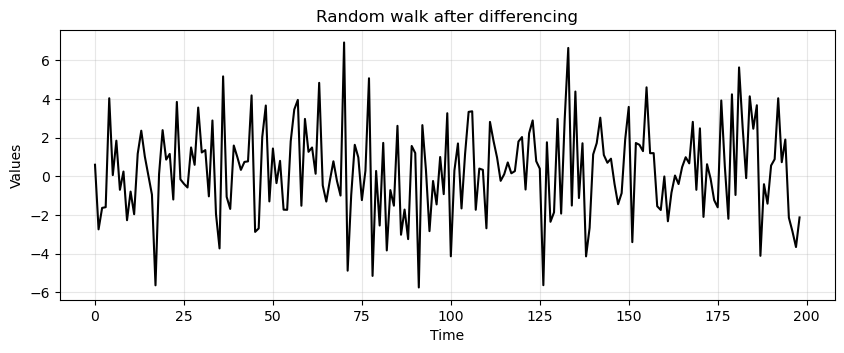

In [ ]:
run_sequence_plot(time[:-1], difference, title="Random walk after differencing");

- Let's run ADF on the differenced data.

In [ ]:
adf_after, pvalue_after, _, _, _, _ = adfuller(difference)
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -15.61
p-value: 0.000


- Now it's stationary!

- Let's see another example.
- We create a small dataframe from 1-10 (linear and squared).

In [ ]:
df = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
df.columns = ['original', 'squared']
df

,original,squared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


- Make stationary the first time series (``original``) so that mean and variance don't change for sub-windows.

In [ ]:
df.original.diff()

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: original, dtype: float64

**📝 NOTE:** This is similar to taking a first-order derivative.

In [ ]:
df.squared.diff().diff()

0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
Name: squared, dtype: float64

- Notice that we need to differentiate twice on the exponential time series.
- Every time we do differencing we lose a bit of data.

- We can also try to make stationary the second time series (``squared``) with log.

In [ ]:
np.log(df.squared)

0    0.000000
1    1.386294
2    2.197225
3    2.772589
4    3.218876
5    3.583519
6    3.891820
7    4.158883
8    4.394449
9    4.605170
Name: squared, dtype: float64

- Works somewhat but certainly not as well as differencing.

- In general we do not know the optimal lag to perform differencing.
- How to determine the optimal order of differentiation will be covered later on.

### Seasonal differentiation

- Consider a time series with a seasonality of period $L$.
- There will be a strong correlation between $X(t)$ and $X(t+L)$.
- Seasonal differentiation can remove the seasonality and make the time series stationary

$$\hat{X}(t) = X(t+L) - X(t)$$

- After seasonal differencing the time series will become $L$ steps shorter.
- Note that we can perform the standard differentiation in cascade to seasonal differentiation if we need to remove also the trend on top of the seasonality.
- Let's see this on the `trend_seasonality` time series.

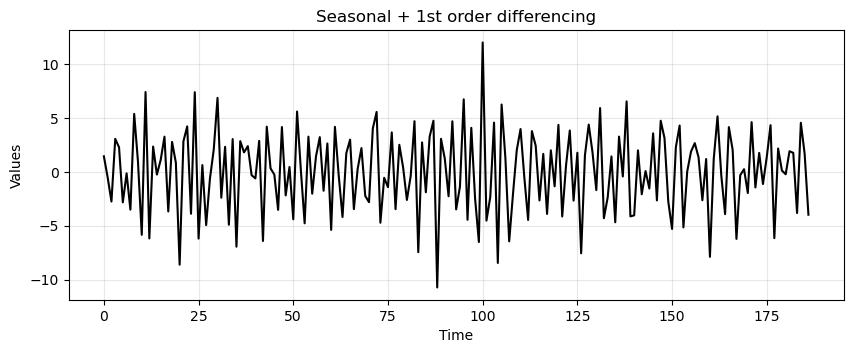

In [ ]:
trend_seasonality_d12 = trend_seasonality[:-12] - trend_seasonality[12:] # remove seasonality
trend_seasonality_d12_d1 = trend_seasonality_d12[:-1] - trend_seasonality_d12[1:] # remove trend

# Plot the differenced time series
run_sequence_plot(time[:-13], trend_seasonality_d12_d1, title="Seasonal + 1st order differencing");

In [ ]:
adf_after, pvalue_after, _, _, _, _ = adfuller(trend_seasonality_d12_d1)
print(f"ADF: {adf_after:.2f}")
print(f"p-value: {pvalue_after:.3f}")

ADF: -5.28
p-value: 0.000


---

## Summary

In this lecture we learned:
1. What does it mean for a time series to be stationary.
2. A set of notable stationary and nonstationary time series.
2. Common tools to identify stationarity.
3. Useful nonstationary-to-stationary transformations.

---

## Exercises

### Exercise 1

- Load the two time series `stationarity_ts1` and `stationarity_ts2` by running the code below.

In [3]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts1.npy?download=1")
response.raise_for_status()
stationarity_ts1 = np.load(BytesIO(response.content))
print(len(stationarity_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts2.npy?download=1")
response.raise_for_status()
stationarity_ts2 = np.load(BytesIO(response.content))
print(len(stationarity_ts2))

100
100


1. Plot the two time series with a run sequence plot.
4. Based on the plot, discuss if each time series seems to be stationary or not.

(array([ 7.,  6.,  9., 10., 16., 24.,  3.,  3.,  7., 15.]),
 array([-1.23429642,  3.68974865,  8.61379373, 13.5378388 , 18.46188387,
        23.38592894, 28.30997401, 33.23401909, 38.15806416, 43.08210923,
        48.0061543 ]),
 <BarContainer object of 10 artists>)

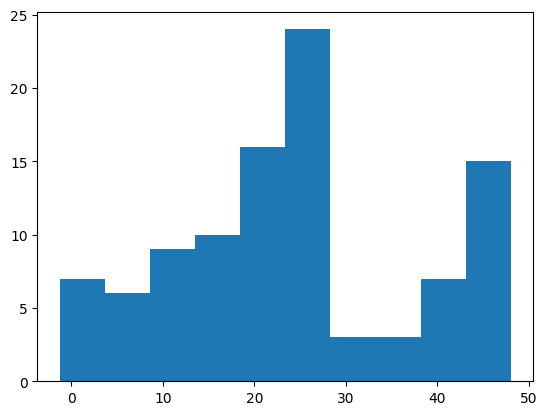

In [17]:
# plt.plot(stationarity_ts1)
plt.hist(stationarity_ts2)

### Exercise 2

Use the following tools to determine if the time series `stationarity_ts1` and `stationarity_ts2` are stationary or not.

1. Summary statistics on the chunks.
2. Histogram plots.
3. Augmented Dickey-Fuller test.

Discuss the result obtained with each method.

In [6]:
chunks = np.split(stationarity_ts1, indices_or_sections=10)
# compare means and variances
for i, chunk in enumerate(chunks, 1):
    print(i, 'mean: %.2f, var: %.2f' % (np.mean(chunk), np.var(chunk)))

1 mean: -0.14, var: 1.11
2 mean: 0.12, var: 1.17
3 mean: 0.05, var: 0.77
4 mean: 4.92, var: 59.92
5 mean: -2.33, var: 55.95
6 mean: -0.37, var: 79.17
7 mean: -1.95, var: 77.82
8 mean: 0.35, var: 3.19
9 mean: 0.30, var: 7.29
10 mean: -0.52, var: 1.35


In [14]:
testval, pvalue, usedlag, nobs, critical_values, icbest = adfuller(stationarity_ts2)
testval, pvalue, usedlag, nobs, critical_values, icbest

(-1.3222642986946496,
 0.6189258221979334,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 350.66221824604816)

### Exercise 3
If either or both datasets from exercises one and two are nonstationary, apply the transformations you learned in this section to make them so. Then apply the methods you learned to ensure stationarity.